In [1]:
import keras
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.getLogger('tensorflow').disabled = True
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D, Reshape
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, restore_best_weights=True)
from sklearn.ensemble import RandomForestClassifier as clf


In [2]:
# import mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
#normalize data
if x_train.max() >1:
    x_train = x_train / 255
    x_test = x_test / 255

default_shape = x_train.shape
#reshape input data to 1 channel
x_train = x_train.reshape(-1,default_shape[1],default_shape[2],1)
x_test = x_test.reshape(-1,default_shape[1],default_shape[2],1)
image_dim = x_train.shape[1:]

# one hot encoding labels
y_train_cat = to_categorical(y_train)
y_test_cat= to_categorical(y_test)

Label = 1 


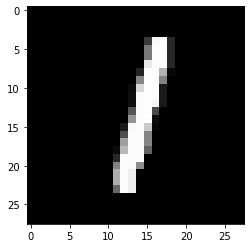

In [4]:
random_label = np.random.randint(0,59999)
plt.imshow(x_train[random_label,:,:], cmap='gray')
print('Label = {} '.format(y_train[random_label]))

In [5]:
################################################################################################

In [57]:
# create a classifier on all the data
classifier_all_labels= clf()
classifier_all_labels.fit(x_train.reshape(-1,28*28),y_train_cat)

In [ ]:
#score of the classifier
classifier_all_labels.score(x_test.reshape(-1,28*28),y_test_cat)

0.9053

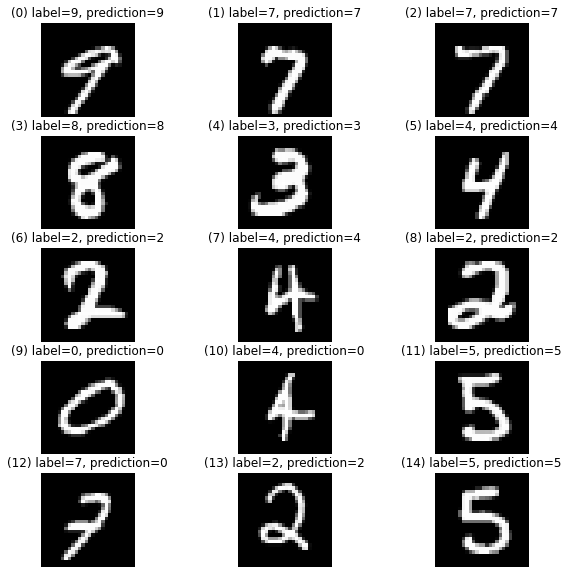

In [8]:
# a test on random images
random_labels = np.random.randint(0,9999,15)
img_samples = x_test[random_labels,:,:,:]
label_samples = y_test[random_labels]
plt.figure(figsize=(10, 10));
for i in range(15):
    plt.subplot(5,3,i+1)
    image = img_samples[i]
    pred = classifier_all_labels.predict(image.reshape(-1,28*28))
    plt.imshow(image, cmap='gray');
    plt.title('({}) label={}, prediction={}'.format(i,label_samples[i],np.argmax(pred)));
    plt.axis('off');

In [41]:
# what if we don't have all the labels
#split the training data into labeled and non labeled
labeled_ratio = 0.001 # 
labeled_index = np.int(len(x_train)*labeled_ratio)
x_train_labeled = x_train[:labeled_index]
x_train_unlabeled = x_train[labeled_index:]
y_train_cat_labeled = y_train_cat[:labeled_index] 
print('Number of labeled data points {} out of {}'.format(labeled_index,x_train.shape[0]))


Number of labeled data points 60 out of 60000


In [42]:
# what if the same model is trained only on a small part of data
classifier_few_labels =  clf()
classifier_few_labels.fit(x_train_labeled.reshape(-1,28*28),y_train_cat_labeled)

RandomForestClassifier()

In [43]:
#score of the classifier
classifier_few_labels.score(x_test.reshape(-1,28*28),y_test_cat)

0.1635

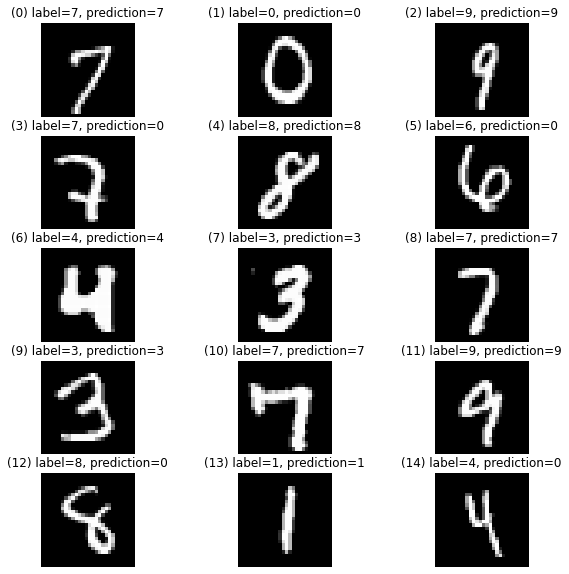

In [12]:
# a test on random images
random_labels = np.random.randint(0,9999,15)
img_samples = x_test[random_labels,:,:,:]
label_samples = y_test[random_labels]
plt.figure(figsize=(10, 10));
for i in range(15):
    plt.subplot(5,3,i+1)
    image = img_samples[i]
    pred = classifier_few_labels.predict(image.reshape(-1,28*28))
    plt.imshow(image, cmap='gray');
    plt.title('({}) label={}, prediction={}'.format(i,label_samples[i],np.argmax(pred)));
    plt.axis('off');

In [13]:
# create an autoencoder / decoder on the whole data (without labels)
encoder = Sequential()
encoder.add(Conv2D(32,kernel_size=(3,3), strides=(1,1),padding='same', input_shape=image_dim, activation='relu'))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same'))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same'))
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
Total params: 92,672
Trainable params: 92,672
Non-trainable params: 0
_________________________________________________________________


In [14]:
encoder_out_dim = encoder.layers[-1].output_shape[1:]
encoder_out_dim

(7, 7, 128)

In [15]:
decoder = Sequential()
decoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same', input_shape=encoder_out_dim, activation='relu'))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same', activation='relu'))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(1,kernel_size=(3,3), strides=(1,1),padding='same', activation='sigmoid'))

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         577       
Total params: 221,953
Trainable params: 221,953
Non-trainable params: 0
_________________________________________________________________


In [16]:
enc_dec = Sequential([encoder,decoder])
enc_dec.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 7, 7, 128)         92672     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         221953    
Total params: 314,625
Trainable params: 314,625
Non-trainable params: 0
_________________________________________________________________


In [17]:
enc_dec.compile(optimizer='nadam', loss = 'binary_crossentropy', metrics=['acc'])

In [18]:
enc_dec.fit(x_train,x_train, batch_size=1000,epochs=1000,validation_split=0.2, verbose=2,callbacks=[es])

Epoch 1/1000
48/48 - 9s - loss: 0.2110 - acc: 0.7911 - val_loss: 0.1156 - val_acc: 0.8109
Epoch 2/1000
48/48 - 8s - loss: 0.1047 - acc: 0.8111 - val_loss: 0.0912 - val_acc: 0.8137
Epoch 3/1000
48/48 - 8s - loss: 0.0939 - acc: 0.8128 - val_loss: 0.0850 - val_acc: 0.8147
Epoch 4/1000
48/48 - 8s - loss: 0.0856 - acc: 0.8140 - val_loss: 0.0816 - val_acc: 0.8154
Epoch 5/1000
48/48 - 8s - loss: 0.0819 - acc: 0.8144 - val_loss: 0.0781 - val_acc: 0.8156
Epoch 6/1000
48/48 - 8s - loss: 0.0787 - acc: 0.8147 - val_loss: 0.0772 - val_acc: 0.8158
Epoch 7/1000
48/48 - 8s - loss: 0.0769 - acc: 0.8149 - val_loss: 0.0758 - val_acc: 0.8158
Epoch 8/1000
48/48 - 9s - loss: 0.0753 - acc: 0.8149 - val_loss: 0.0766 - val_acc: 0.8156
Epoch 9/1000
48/48 - 9s - loss: 0.0741 - acc: 0.8150 - val_loss: 0.0737 - val_acc: 0.8158
Epoch 10/1000
48/48 - 8s - loss: 0.0735 - acc: 0.8151 - val_loss: 0.0721 - val_acc: 0.8160
Epoch 11/1000
48/48 - 8s - loss: 0.0724 - acc: 0.8151 - val_loss: 0.0730 - val_acc: 0.8160
Epoch 12

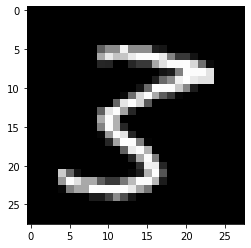

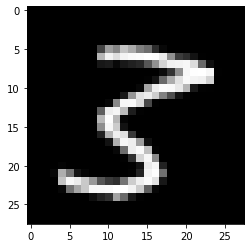

In [19]:
random_label = np.random.randint(0,59999)
img_sample = x_train[random_label,:,:]
plt.imshow(img_sample, cmap='gray');
pred_img = enc_dec.predict(img_sample.reshape((1,28,28,1))) 
plt.figure();
plt.imshow(pred_img.reshape(28,28,1), cmap='gray');


In [44]:
dense_encoder = Sequential()
dense_encoder.add(Flatten(input_shape = encoder_out_dim ))
dense_encoder.add(Dense(10,activation = 'softmax'))
dense_encoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                62730     
Total params: 62,730
Trainable params: 62,730
Non-trainable params: 0
_________________________________________________________________


In [45]:
encoder.trainable = False
labeler = Sequential([encoder, dense_encoder])
labeler.summary()
labeler.compile(optimizer='nadam', loss = 'categorical_crossentropy', metrics=['CategoricalAccuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 7, 7, 128)         92672     
_________________________________________________________________
sequential_7 (Sequential)    (None, 10)                62730     
Total params: 155,402
Trainable params: 62,730
Non-trainable params: 92,672
_________________________________________________________________


In [46]:
# train the last layer only on the available labels
labeler.fit(x_train_labeled,y_train_cat_labeled, epochs=1000,validation_split=0.2, callbacks=[es])

Epoch 1/1000
2/2 [==============================] - 0s 129ms/step - loss: 2.3058 - categorical_accuracy: 0.0625 - val_loss: 1.7570 - val_categorical_accuracy: 0.5833
Epoch 2/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.6017 - categorical_accuracy: 0.6250 - val_loss: 1.5229 - val_categorical_accuracy: 0.5833
Epoch 3/1000
2/2 [==============================] - 0s 17ms/step - loss: 1.1798 - categorical_accuracy: 0.7708 - val_loss: 1.3577 - val_categorical_accuracy: 0.6667
Epoch 4/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.8814 - categorical_accuracy: 0.9167 - val_loss: 1.2272 - val_categorical_accuracy: 0.5833
Epoch 5/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.6531 - categorical_accuracy: 0.9583 - val_loss: 1.1317 - val_categorical_accuracy: 0.6667
Epoch 6/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.4732 - categorical_accuracy: 1.0000 - val_loss: 1.0883 - val_categorical_accuracy: 0.6667
Epoch 7/1

In [47]:
labeler.evaluate(x_test,y_test_cat)

313/313 [==============================] - 1s 4ms/step - loss: 1.0365 - categorical_accuracy: 0.6699


[1.0365440845489502, 0.6699000000953674]

In [48]:
labeler.evaluate(x_train,y_train_cat)

1875/1875 [==============================] - 6s 3ms/step - loss: 1.0277 - categorical_accuracy: 0.6788


[1.0277137756347656, 0.6788333058357239]

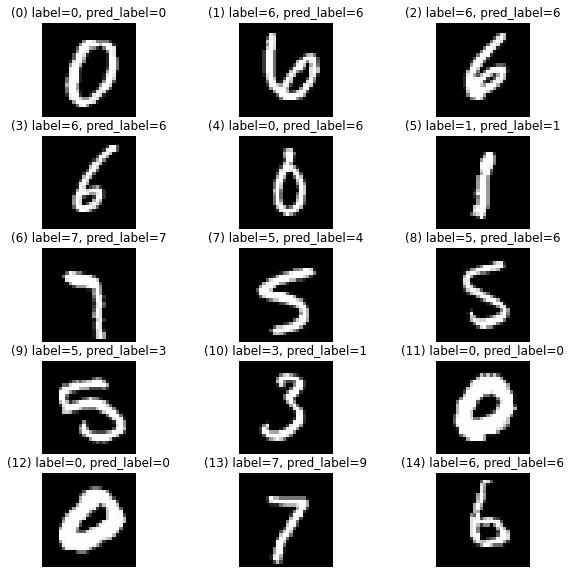

In [49]:
# a test on random images
random_labels = np.random.randint(0,9999,15)
img_samples = x_test[random_labels,:,:,:]
label_samples = y_test[random_labels]
predicted_labels = labeler.predict(img_samples)
plt.figure(figsize=(10, 10));
for i in range(15):
    plt.subplot(5,3,i+1)
    pred_label = np.argmax(predicted_labels[i])+1
    image = img_samples[i]
    plt.imshow(image, cmap='gray');
    plt.title('({}) label={}, pred_label={}'.format(i,label_samples[i],np.argmax(predicted_labels[i])));
    plt.axis('off');


In [50]:
new_labels = np.round(labeler.predict(x_train_unlabeled))

In [51]:
# improve the weak classifier using the new labeled data
classifier_generated_labels = clf()
classifier_generated_labels.fit(x_train.reshape(-1,28*28),np.concatenate((y_train_cat_labeled,new_labels)))


RandomForestClassifier()

In [52]:
# score on the test labels
classifier_generated_labels.score(x_test.reshape(-1,28*28),y_test_cat)

0.4972